# We will filter and analyze the 311 complaints first 

In [1]:
import glob
import json
import requests
import pandas as pd
from pprint import pprint

# show all columns
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('311_street_lights.csv')

In [3]:
len(df)

316541

In [4]:
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts
0,57090793,03/21/2023 12:32:00 AM,NaN,DOT,Department of Transportation,Street Light Condition,Fixture/Luminaire Hanging,NaN,10027.0,3174 BROADWAY,BROADWAY,LA SALLE ST,TIEMANN PL,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Open,NaN,NaN,NaN,09 MANHATTAN,NaN,MANHATTAN,995657.0,236200.0,UNKNOWN,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.814983,-73.958790,"(40.81498280473526, -73.95879012453169)",12424.0,37.0,4.0,23.0,17.0
1,57093090,03/20/2023 11:27:00 PM,NaN,DOT,Department of Transportation,Street Light Condition,Street Light Lamp Dim,NaN,11236.0,NaN,NaN,NaN,NaN,AVENUE J,EAST 86 STREET,INTERSECTION,BROOKLYN,NaN,NaN,Open,NaN,NaN,NaN,18 BROOKLYN,NaN,BROOKLYN,1010050.0,171256.0,UNKNOWN,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.636697,-73.907042,"(40.63669717144956, -73.907041786675)",13827.0,5.0,2.0,8.0,42.0
2,57092172,03/20/2023 10:20:00 PM,NaN,DOT,Department of Transportation,Street Light Condition,Street Light Dayburning,NaN,11357.0,NaN,NaN,NaN,NaN,25 AVENUE,150 STREET,INTERSECTION,QUEENS,NaN,NaN,Open,NaN,NaN,NaN,07 QUEENS,NaN,QUEENS,1035504.0,221998.0,UNKNOWN,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.775861,-73.814944,"(40.77586093296771, -73.81494419575927)",13832.0,22.0,3.0,20.0,67.0
3,57090601,03/20/2023 10:05:00 PM,NaN,DOT,Department of Transportation,Street Light Condition,Street Light Out,NaN,11691.0,20-19 ELK COURT,ELK COURT,BEACH 20 ST,UNNAMED ST,NaN,NaN,ADDRESS,FAR ROCKAWAY,NaN,NaN,Open,NaN,NaN,NaN,14 QUEENS,4.157688e+09,QUEENS,1052354.0,157325.0,UNKNOWN,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.598235,-73.754760,"(40.59823537247661, -73.75476021423908)",20529.0,51.0,3.0,47.0,59.0
4,57097644,03/20/2023 09:14:00 PM,NaN,DOT,Department of Transportation,Street Light Condition,Street Light Out,NaN,11368.0,NaN,NaN,NaN,NaN,34 AVENUE,NORTHERN BLVD EXIT,INTERSECTION,QUEENS,NaN,NaN,Open,NaN,NaN,NaN,07 QUEENS,NaN,QUEENS,1027054.0,216104.0,UNKNOWN,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.759728,-73.845491,"(40.75972841557144, -73.84549092094751)",14510.0,67.0,3.0,21.0,68.0


In [5]:
df = df.rename(columns={'Latitude': 'latitude', 'Longitude': 'longitude'})

In [6]:
# TODO - make sure this is a sound choice
to_delete = df.query("latitude.isnull()")
to_delete.to_csv('deleted_streetlight_complaints.csv', index=False)

# filter out the nulls 
df = df.query("latitude.notnull()")
df = df.query("longitude.notnull()")


## We would geocode the complaints with no latitude and longitude, but because there are about 100,000 rows, we would need a few days to do it, as there is a limit of 40,000 geocodes we can do for free with Google's geocoding API.

In [7]:
# Code adapted from:
# https://gis.stackexchange.com/questions/363830/applying-the-censusgeocode-package-to-an-entire-dataframe-of-geocoded-data
# Defines a geocode function that accepts lat/long and spits out geographies
# The code then runs that funciton in parllel (for speed).

import pandas as pd
import censusgeocode as cg
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

import requests_cache
cache = requests_cache.CachedSession("geocode_cache", backend="filesystem")

def geocode(lat, lng):
    try:
        url = "https://geocoding.geo.census.gov/geocoder/geographies/coordinates"
        params = {
            "x": lng,
            "y": lat,
            "benchmark": "Public_AR_Census2020",
            "vintage": "Census2020_Census2020",
            "format": "json"
        }
        response = cache.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        census = data['result']['geographies']['Census Blocks'][0]
        return census
    except Exception as e:
        print(f"Error geocoding ({lat}, {lng}): {e}")
        return None

def bulk_geocode(latitudes, longitudes):
    """
    Geocode a list of latitudes and longitudes in parallel (for speed).
    """

    with ThreadPoolExecutor() as tpe:
        #latitudes = df['lat']
        #longitudes = df['long']
        mapped_results = tpe.map(geocode, latitudes, longitudes)
        data = list(tqdm(mapped_results, total=len(df)))

    return pd.DataFrame(data)

Street_light_complants_with_census = bulk_geocode(df['latitude'], df['longitude']) 
Street_light_complants_with_census.head()


  0%|          | 0/215845 [00:00<?, ?it/s]

,SUFFIX,POP100,GEOID,CENTLAT,BLOCK,AREAWATER,STATE,BASENAME,OID,LSADC,INTPTLAT,FUNCSTAT,NAME,OBJECTID,TRACT,CENTLON,BLKGRP,AREALAND,HU100,INTPTLON,MTFCC,LWBLKTYP,UR,COUNTY
0,,1196,360610211004001,+40.8142340,4001,0,36,4001,210701008621778,BK,+40.8142340,S,Block 4001,3458704,021100,-073.9589119,4,10086,453,-073.9589119,G5040,L,U,061
1,,494,360470956002002,+40.6372852,2002,0,36,2002,210701004655869,BK,+40.6372852,S,Block 2002,8101677,095600,-073.9083328,2,19794,169,-073.9083328,G5040,L,U,047
2,,252,360811047002000,+40.7740488,2000,0,36,2000,210701006114712,BK,+40.7740488,S,Block 2000,3246362,104700,-073.8164080,2,93084,83,-073.8164080,G5040,L,U,081
3,,163,360810998013003,+40.5979241,3003,0,36,3003,210701006107620,BK,+40.5979241,S,Block 3003,2938424,099801,-073.7551005,3,14534,57,-073.7551005,G5040,L,U,081
4,,12,360810383021089,+40.7561438,1089,0,36,1089,210701006110921,BK,+40.7561438,S,Block 1089,1738002,038302,-073.8475395,1,290744,1,-073.8475395,G5040,L,U,081


In [ ]:
to_keep = ['GEOID', 'STATE', 'COUNTY', 'TRACT', 'BLOCK']
Street_light_complants_with_census = Street_light_complants_with_census[to_keep]
Street_light_complants_with_census

In [57]:
Street_light_complants_with_census['GEOID'] = Street_light_complants_with_census['GEOID'].astype(str).str[:-4]

In [58]:
Street_light_complants_with_census = Street_light_complants_with_census.rename(columns={'GEOID': 'geoid'})

In [59]:
Street_light_complants_with_census = pd.concat(
    [ 
        df.reset_index(drop=True),
        Street_light_complants_with_census.reset_index(drop=True)
    ], 
    axis=1)

Street_light_complants_with_census.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,latitude,longitude,Location,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts,geoid,STATE,COUNTY,TRACT,BLOCK
0,57090793,03/21/2023 12:32:00 AM,NaN,DOT,Department of Transportation,Street Light Condition,Fixture/Luminaire Hanging,NaN,10027.0,3174 BROADWAY,BROADWAY,LA SALLE ST,TIEMANN PL,NaN,NaN,ADDRESS,NEW YORK,NaN,NaN,Open,NaN,NaN,NaN,09 MANHATTAN,NaN,MANHATTAN,995657.0,236200.0,UNKNOWN,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.814983,-73.958790,"(40.81498280473526, -73.95879012453169)",12424.0,37.0,4.0,23.0,17.0,36061021100,36,61,21100,4001
1,57093090,03/20/2023 11:27:00 PM,NaN,DOT,Department of Transportation,Street Light Condition,Street Light Lamp Dim,NaN,11236.0,NaN,NaN,NaN,NaN,AVENUE J,EAST 86 STREET,INTERSECTION,BROOKLYN,NaN,NaN,Open,NaN,NaN,NaN,18 BROOKLYN,NaN,BROOKLYN,1010050.0,171256.0,UNKNOWN,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.636697,-73.907042,"(40.63669717144956, -73.907041786675)",13827.0,5.0,2.0,8.0,42.0,36047095600,36,47,95600,2002
2,57092172,03/20/2023 10:20:00 PM,NaN,DOT,Department of Transportation,Street Light Condition,Street Light Dayburning,NaN,11357.0,NaN,NaN,NaN,NaN,25 AVENUE,150 STREET,INTERSECTION,QUEENS,NaN,NaN,Open,NaN,NaN,NaN,07 QUEENS,NaN,QUEENS,1035504.0,221998.0,UNKNOWN,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.775861,-73.814944,"(40.77586093296771, -73.81494419575927)",13832.0,22.0,3.0,20.0,67.0,36081104700,36,81,104700,2000
3,57090601,03/20/2023 10:05:00 PM,NaN,DOT,Department of Transportation,Street Light Condition,Street Light Out,NaN,11691.0,20-19 ELK COURT,ELK COURT,BEACH 20 ST,UNNAMED ST,NaN,NaN,ADDRESS,FAR ROCKAWAY,NaN,NaN,Open,NaN,NaN,NaN,14 QUEENS,4.157688e+09,QUEENS,1052354.0,157325.0,UNKNOWN,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.598235,-73.754760,"(40.59823537247661, -73.75476021423908)",20529.0,51.0,3.0,47.0,59.0,36081099801,36,81,99801,3003
4,57097644,03/20/2023 09:14:00 PM,NaN,DOT,Department of Transportation,Street Light Condition,Street Light Out,NaN,11368.0,NaN,NaN,NaN,NaN,34 AVENUE,NORTHERN BLVD EXIT,INTERSECTION,QUEENS,NaN,NaN,Open,NaN,NaN,NaN,07 QUEENS,NaN,QUEENS,1027054.0,216104.0,UNKNOWN,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.759728,-73.845491,"(40.75972841557144, -73.84549092094751)",14510.0,67.0,3.0,21.0,68.0,36081038302,36,81,38302,1089


In [60]:
len(Street_light_complants_with_census)

215845

In [61]:
Street_light_complants_with_census = Street_light_complants_with_census['geoid'].value_counts()

Street_light_complants_with_census = pd.DataFrame({'geoid': Street_light_complants_with_census.index, 'complaints_count': Street_light_complants_with_census.values})

In [13]:
Street_light_complants_with_census.to_csv('Street_light_complants_with_census.csv', index=False)

In [43]:
census_details = pd.read_csv("census_data_merged_edit.csv")
census_details.head()

,Unnamed: 0,geoid,name,total_population,poc_percent,female_pop_percent,poverty_level_percent,over_65_percent
0,0,14000US36005000100,"Census Tract 1, Bronx, NY",6661,59.765801,7.266176,0.000000,1.351148
1,1,14000US36005000200,"Census Tract 2, Bronx, NY",4453,72.265888,44.397036,22.771166,18.549293
2,2,14000US36005000400,"Census Tract 4, Bronx, NY",6000,69.850000,49.766667,4.000000,15.550000
3,3,14000US36005001600,"Census Tract 16, Bronx, NY",6038,83.504472,58.396820,15.750248,19.161974
4,4,14000US36005001901,"Census Tract 19.01, Bronx, NY",2168,69.372694,54.197417,27.490775,1.522140


In [44]:
census_details['geoid'] = census_details['geoid'].str.replace('14000US', '')
census_details.head()

,Unnamed: 0,geoid,name,total_population,poc_percent,female_pop_percent,poverty_level_percent,over_65_percent
0,0,36005000100,"Census Tract 1, Bronx, NY",6661,59.765801,7.266176,0.000000,1.351148
1,1,36005000200,"Census Tract 2, Bronx, NY",4453,72.265888,44.397036,22.771166,18.549293
2,2,36005000400,"Census Tract 4, Bronx, NY",6000,69.850000,49.766667,4.000000,15.550000
3,3,36005001600,"Census Tract 16, Bronx, NY",6038,83.504472,58.396820,15.750248,19.161974
4,4,36005001901,"Census Tract 19.01, Bronx, NY",2168,69.372694,54.197417,27.490775,1.522140


# Now we will filter and analyze the traffic crashes based on NYPD data

In [7]:
traffic_crashes_census= pd.read_csv('traffic_crashes_census.csv')
traffic_crashes_census.head()

/var/folders/x2/ld74q9c55_j9mn_p0hkl_0640000gn/T/ipykernel_13182/3608478923.py:1: DtypeWarning: Columns (15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  traffic_crashes_census= pd.read_csv('traffic_crashes_census.csv')


,Unnamed: 0,CRASH DATE,CRASH TIME,BOROUGH,zipcode,latitude,longitude,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,address,address_full,Unnamed: 15,Unnamed: 16,Unnamed: 17,GEOID,STATE,COUNTY,TRACT,BLOCK
0,11,03/20/2018,2023-05-01 20:00:00,BROOKLYN,11229.0,40.610947,-73.953606,"(40.610947, -73.953606)",AVENUE P,OCEAN AVENUE,NaN,0.0,0.0,AVENUE P & OCEAN AVENUE,"AVENUE P & OCEAN AVENUE, BROOKLYN",NaN,NaN,NaN,360470550003001,36,47,55000,3001
1,14,03/20/2018,2023-05-01 21:00:00,BROOKLYN,11226.0,40.648720,-73.964910,"(40.64872, -73.96491)",CHURCH AVENUE,EAST 16 STREET,NaN,0.0,0.0,CHURCH AVENUE & EAST 16 STREET,"CHURCH AVENUE & EAST 16 STREET, BROOKLYN",NaN,NaN,NaN,360470506002001,36,47,50600,2001
2,21,03/20/2018,2023-05-01 20:18:00,MANHATTAN,10016.0,40.749350,-73.982770,"(40.74935, -73.98277)",NaN,NaN,12 EAST 36 STREET,0.0,0.0,12 EAST 36 STREET,"12 EAST 36 STREET, MANHATTAN",NaN,NaN,NaN,360610082002007,36,61,8200,2007
3,23,03/20/2018,2023-05-01 20:20:00,QUEENS,11420.0,40.675083,-73.809586,"(40.675083, -73.809586)",NaN,NaN,128-24 ROCKAWAY BOULEVARD,0.0,0.0,128-24 ROCKAWAY BOULEVARD,"128-24 ROCKAWAY BOULEVARD, QUEENS",NaN,NaN,NaN,360810818003000,36,81,81800,3000
4,26,03/20/2018,2023-05-01 06:50:00,STATEN ISLAND,10306.0,40.569893,-74.110344,"(40.569893, -74.110344)",HYLAN BOULEVARD,CODDINGTON AVENUE,NaN,0.0,0.0,HYLAN BOULEVARD & CODDINGTON AVENUE,"HYLAN BOULEVARD & CODDINGTON AVENUE, STATEN IS...",NaN,NaN,NaN,360850134001022,36,85,13400,1022


In [8]:
traffic_crashes_census = traffic_crashes_census.rename(columns={'GEOID': 'geoid'})

In [9]:
traffic_crashes_total = traffic_crashes_census['geoid'].value_counts().to_dict()

traffic_crashes_total = pd.DataFrame({'geoid': list(traffic_crashes_total.keys()), 'total_crashes': list(traffic_crashes_total.values())})

In [ ]:
all_data = census_details.merge(traffic_crashes_total.set_index(['geoid']), 
                      left_on=['geoid'], 
                      right_index=True, 
                      how='left')

In [63]:
all_data_final = Street_light_complants_with_census.merge(all_data.set_index(['geoid']), 
                      left_on=['geoid'], 
                      right_index=True, 
                      how='left')

In [64]:
all_data_final.head()

,geoid,complaints_count,Unnamed: 0,name,total_population,poc_percent,female_pop_percent,poverty_level_percent,over_65_percent,total_crashes
0,36061014300,1075,1324.0,"Census Tract 143, New York, NY",0.0,NaN,NaN,NaN,NaN,334.0
1,36005009301,722,65.0,"Census Tract 93.01, Bronx, NY",4928.0,83.583604,52.678571,34.719968,6.696429,425.0
2,36005009302,683,66.0,"Census Tract 93.02, Bronx, NY",566.0,81.272085,0.000000,0.000000,1.766784,402.0
3,36005051601,627,359.0,"Census Tract 516.01, Bronx, NY",4417.0,23.047317,48.811410,6.158026,24.722662,128.0
4,36081093800,601,2066.0,"Census Tract 938, Queens, NY",5289.0,25.392324,52.788807,16.808470,26.734732,117.0


In [66]:
all_data_final.to_csv('crashes_complaints_census_details.csv', index=False)

In [67]:
to_fill_manually = all_data_final.query("poc_percent.isnull()")
to_fill_manually.to_csv('to_fill_manually.csv', index=False)

# filter out the nulls 
all_data_final = all_data_final.query("poc_percent.notnull()")

In [ ]:
#concat both dfs after filling manually
all_data_final = pd.concat([to_fill_manually, all_data_final], axis=0)

In [79]:
#remove places which are underpopulated 
all_data_final = all_data_final[all_data_final['total_population'] > 100]

In [80]:
all_data_final['complaints_per_capita'] = all_data_final['complaints_count'] / all_data_final['total_population']
all_data_final['crashes_per_capita'] = all_data_final['total_crashes'] / all_data_final['total_population']

In [ ]:
all_data_final.sort_values(by='complaints_count', ascending=False)

In [ ]:
all_data_final.sort_values(by='complaints_per_capita', ascending=False)

In [86]:
all_data_final.to_csv('crashes_complaints_census_details.csv', index=False)

In [ ]:
all_data_final_2 =  all_data_final.sort_values(by='crashes_per_capita', ascending=False)
all_data_final_2

# Regressing complaints per capita, crashes per capita, and the demographics of each census tract

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
%%R

require('tidyverse')

In [4]:
%%R

df <- read_csv('crashes_complaints_census_details.csv')
df

Rows: 2220 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): name
dbl (11): geoid, complaints_count, Unnamed: 0, total_population, poc_percent...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 2,220 × 12
     geoid compl…¹ Unnam…² name  total…³ poc_p…⁴ femal…⁵ pover…⁶ over_…⁷ total…⁸
     <dbl>   <dbl>   <dbl> <chr>   <dbl>   <dbl>   <dbl>   <dbl>   <dbl>   <dbl>
 1 3.60e10     722      65 Cens…    4928   83.6     52.7   34.7     6.70     425
 2 3.60e10     683      66 Cens…     566   81.3      0      0       1.77     402
 3 3.60e10     627     359 Cens…    4417   23.0     48.8    6.16   24.7      128
 4 3.61e10     601    2066 Cens…    5289   25.4     52.8   16.8    26.7      117
 5 3.61e10     576    2289 Cens…    7733    9.14    52.3    8.95   13.0       93
 6 3.61e10     560    2052 Cens…    9069 

In [8]:
%%R

require('ggrepel')
library(ggrepel)

`geom_smooth()` using formula = 'y ~ x'


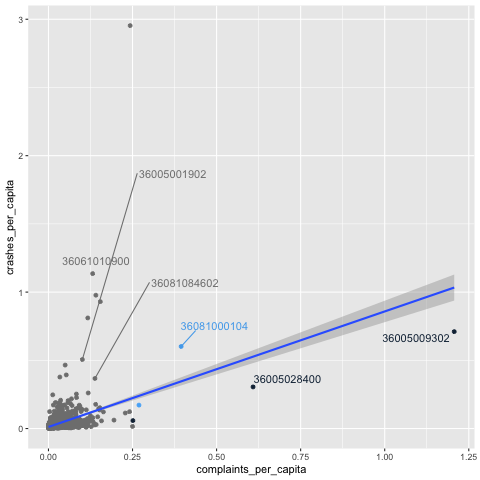

In [12]:
%%R

# replace these vectors with the actual data
census_tracts_most_complaints_per_capita <- c(36005009302,36005028400,36081000104,36085022602, 36005028600)
census_tracts_most_crashes_per_capita <- c(36061011300,36061010900,36061009600,36061010200,36081019901)

ggplot(df) +
    aes(x=complaints_per_capita, y=crashes_per_capita, label=geoid, color=ifelse(geoid %in% census_tracts_most_complaints_per_capita, geoid, NA)) +
    scale_y_continuous(labels = function(x) format(x, scientific = FALSE)) +
    geom_text_repel() +
    geom_point() +
    geom_smooth(method='lm') +
    guides(color=FALSE)


In [13]:
%%R

complaints_v_crashes <- lm(complaints_per_capita ~ crashes_per_capita, data=df)
summary(complaints_v_crashes)



Call:
lm(formula = complaints_per_capita ~ crashes_per_capita, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.33486 -0.01569 -0.00722  0.00638  1.05104 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        0.021990   0.000833   26.40   <2e-16 ***
crashes_per_capita 0.188220   0.009178   20.51   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03607 on 2218 degrees of freedom
Multiple R-squared:  0.1594,	Adjusted R-squared:  0.159 
F-statistic: 420.6 on 1 and 2218 DF,  p-value: < 2.2e-16



In [15]:
%%R
 
complaints_v_demographics <- lm(complaints_per_capita ~ poc_percent + female_pop_percent + poverty_level_percent + over_65_percent, data=df)
summary(complaints_v_demographics)


Call:
lm(formula = complaints_per_capita ~ poc_percent + female_pop_percent + 
    poverty_level_percent + over_65_percent, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.08407 -0.01737 -0.00680  0.00789  1.09495 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            1.117e-01  7.604e-03  14.685  < 2e-16 ***
poc_percent           -7.126e-06  3.081e-05  -0.231 0.817113    
female_pop_percent    -1.682e-03  1.474e-04 -11.413  < 2e-16 ***
poverty_level_percent -8.184e-05  7.478e-05  -1.094 0.273880    
over_65_percent        3.816e-04  1.137e-04   3.356 0.000803 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03814 on 2215 degrees of freedom
Multiple R-squared:  0.06142,	Adjusted R-squared:  0.05973 
F-statistic: 36.24 on 4 and 2215 DF,  p-value: < 2.2e-16



In [21]:
%%R

print(df %>% summary)

print(sd(df$complaints_per_capita))

     geoid           complaints_count   Unnamed: 0         name          
 Min.   :3.601e+10   Min.   :  1.00   Min.   :   1.0   Length:2220       
 1st Qu.:3.605e+10   1st Qu.: 40.00   1st Qu.: 582.8   Class :character  
 Median :3.605e+10   Median : 69.00   Median :1156.5   Mode  :character  
 Mean   :3.605e+10   Mean   : 93.17   Mean   :1158.9                     
 3rd Qu.:3.608e+10   3rd Qu.:117.00   3rd Qu.:1739.2                     
 Max.   :3.609e+10   Max.   :722.00   Max.   :2325.0                     
 total_population  poc_percent     female_pop_percent poverty_level_percent
 Min.   :  107    Min.   :  0.00   Min.   : 0.00      Min.   : 0.000       
 1st Qu.: 2479    1st Qu.: 35.91   1st Qu.:48.60      1st Qu.: 7.176       
 Median : 3625    Median : 65.83   Median :51.76      Median :12.878       
 Mean   : 3930    Mean   : 60.64   Mean   :51.76      Mean   :15.879       
 3rd Qu.: 5007    3rd Qu.: 86.80   3rd Qu.:54.93      3rd Qu.:21.270       
 Max.   :16629    Max.   :

In [16]:
%%R

complaints_v_all <- lm(complaints_per_capita ~ poc_percent + female_pop_percent + poverty_level_percent + over_65_percent + crashes_per_capita, data=df)
summary(complaints_v_all)


Call:
lm(formula = complaints_per_capita ~ poc_percent + female_pop_percent + 
    poverty_level_percent + over_65_percent + crashes_per_capita, 
    data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.31246 -0.01516 -0.00613  0.00688  1.00561 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            8.011e-02  7.264e-03  11.029  < 2e-16 ***
poc_percent           -3.862e-05  2.868e-05  -1.347   0.1782    
female_pop_percent    -1.072e-03  1.408e-04  -7.615 3.89e-14 ***
poverty_level_percent -1.767e-04  6.967e-05  -2.535   0.0113 *  
over_65_percent        1.959e-04  1.061e-04   1.846   0.0650 .  
crashes_per_capita     1.743e-01  9.298e-03  18.744  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03544 on 2214 degrees of freedom
Multiple R-squared:   0.19,	Adjusted R-squared:  0.1881 
F-statistic: 103.8 on 5 and 2214 DF,  p-value: < 2.2e-16

